In [1]:
%matplotlib notebook
# %matplotlib inline

from itertools import cycle
from itertools import combinations as comb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import lasso_path, enet_path
from sklearn.linear_model import LassoCV, ElasticNetCV, ElasticNet
from sklearn.preprocessing import scale, PolynomialFeatures

from scipy import io
import design_space_utils as utils

import warnings


In [2]:
def read_design_space(fn, inverse=False, normalize=False, time='Total_time'):
    
    df = utils.read_design_space(filename=fn, time=time)
    
    names = []
    for x in df:
        if x.startswith('knob_'):
            #if np.any(df[x] != df[x][0]): names.append(x)
            names.append(x)
    X = df[names].values
    
    t = df[time]
    l = df['logic']
    if 'ate' in df:
        e = df['ate']
    else:
        e = np.ones(len(l))

    if inverse:
        t = 1/t
        l = 1/l
        e = 1/e
    
    if normalize:
        t = utils.normalize(t)
        l = utils.normalize(l)
        e = utils.normalize(e)

    y = np.c_[t,l,e]
    
    return X.astype(np.float64), y.astype(np.float64), np.array(names)



class MyLasso:
    
    def __init__(self,
                 inverse=True,  # Model the inverse of the objective
                 time_csv='Total_time', # Which timecounter to use for time objective
                 poly=PolynomialFeatures(2, interaction_only=True), # Generate polynomial and interaction features
                 l1_ratio=1, # 0=Ridge, 1=LASSO
                 print_coefs=False,
                 plot_data=False,
                 n_jobs=1):
    
        self.inverse = inverse
        self.time_csv = time_csv
        self.poly = poly
        self.l1_ratio = l1_ratio
        self.n_jobs = n_jobs
        self.print_coefs = print_coefs
        self.plot_data = plot_data
    
    
    def run_lasso(self,
                  filename,
                  objective_idx, # Which column of y to use
                  inverse=True,  # Model the inverse of the objective
                  time_csv='Total_time', # Which timecounter to use for time objective
                  poly=None,
                  l1_ratio=None,
                  n_jobs=None,
                  print_coefs=None,
                  plot_data=None
                 ):

        
        if inverse is None:
            inverse = self.inverse
        if time_csv is None:
            time_csv = self.time_csv
        if poly is None:
            poly = self.poly
        if l1_ratio is None:
            l1_ratio = self.l1_ratio
        if n_jobs is None:
            n_jobs = self.n_jobs
        if print_coefs is None:
            print_coefs = self.print_coefs
        if plot_data is None:
            plot_data = self.plot_data
        
        X,y,names = read_design_space(filename, inverse=inverse, normalize=True, time=time_csv)
        
        if names is None:
            names = [ 'Knob' + str(i) for i in range(1,X.shape[1]+1)]
        else:
            for i,n in enumerate(names):
                if n.startswith("knob_"):
                    names[i] = "".join(n[5:].title().split("_"))

    #     X+=1 # Remove zeros
        y = y[:,objective_idx]


        # Remove constant knobs
        non_constant_knobs = np.any(X != X[0,:], axis = 0)
        X = X[:,non_constant_knobs]
        names = names[non_constant_knobs]



        auto_scale = False

        if not auto_scale:
    #         Xstd = np.std(X, axis=0)
    #         X -= X.mean(axis=0)
    #         X /= Xstd

            X = scale(X, axis=0)

    #         Xnorm = np.linalg.norm(X, axis=0)
    #         X -= X.mean(axis=0)
    #         X /= Xnorm

            X[np.isinf(X)] = 0
            X[np.isnan(X)] = 0



        # Generate polynomial features from knobs
        X = poly.fit_transform(X)
        names = poly.get_feature_names(list(names))

    #     # Remove duplicates (?)
    #     _, uniqueX_idx = np.unique(X, axis=1, return_index=True)
    #     X = X[:,sorted(uniqueX_idx)]
    #     names = np.array(names)[sorted(uniqueX_idx)]
        names = np.array(names)


        # Compute LASSO

        eps = 1e-4  # the smaller it is the longer is the path
#         alpha_grid = np.logspace(np.log10(0.00001), np.log10(0.1), num=100)[::-1]
        alpha_grid = np.append(np.logspace(np.log10(0.00001), np.log10(1), num=100)[::-1], 0)
    #     alpha_grid = None

        # This computes the best alpha using cross-validation
        lasso = ElasticNetCV(l1_ratio=l1_ratio, eps=eps, alphas=alpha_grid, fit_intercept=auto_scale, cv=10, normalize=auto_scale,
                            n_jobs=n_jobs)
        lasso.fit(X, y)

        best_coefs = lasso.coef_


        # This computes all the alphas with all the data
        alphas_lasso, coefs_lasso, _ = lasso.path(X, y, l1_ratio=l1_ratio, alphas=lasso.alphas_, fit_intercept=auto_scale, normalize=auto_scale, n_jobs=n_jobs)



        mse = np.mean(lasso.mse_path_, axis=1)
        mse_std = np.std(lasso.mse_path_, axis=1)
        mse_min_idx = np.argmin(mse)

        best_coefs = coefs_lasso[:,mse_min_idx] # In theory, this is the same as lasso.coef_, but apparently not in practice


        # Sort and print coefficients (absolute values)

        sorted_coef_idx = np.argsort(np.abs(best_coefs))
        sorted_coefs = coefs_lasso[:,mse_min_idx][sorted_coef_idx]
        sorted_names = names[sorted_coef_idx]

        sorted_coefs_names = zip(sorted_coefs, sorted_names)

        if print_coefs:
            print("\n".join([str(c)+","+n for c,n in sorted_coefs_names if np.abs(c) > 0]))

        print("MSE " + str(np.min(mse)) + " std " + str(mse_std[mse_min_idx]) + "")


        # Plot results
        if plot_data:

            figure = plt.figure()
            ax1 = figure.add_subplot(3,1,1)
            ax2 = figure.add_subplot(3,1,2)
            # ax3 = figure.add_subplot(1,2,2)
            ax4 = figure.add_subplot(3,1,3)

            colors = cycle(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#00ff99','#b15928'])

            neg_log_alphas_lasso = -np.log10(alphas_lasso)

            for coef_l, c, n in zip(coefs_lasso, colors, names):
#                 l1 = ax1.plot(neg_log_alphas_lasso, coef_l, c=c, label=n)
                l1 = ax1.semilogx(alphas_lasso, coef_l, c=c, label=n)
#             ax1.axvline(neg_log_alphas_lasso[mse_min_idx], linestyle=":")
            ax1.axvline(alphas_lasso[mse_min_idx], linestyle=":")

#             ax1.set_xlabel('-log$_{10}$(alpha)')
            ax1.set_xlabel('Alpha')
            ax1.set_ylabel('Coefficients')
            ax1.set_title('LASSO Paths')
            # plt.legend((l1), ('Lasso'), loc='lower left')
            # plt.legend(loc='lower left')
            ax1.invert_xaxis()

            ax2.errorbar(alphas_lasso, mse, yerr=mse_std, # neg_log_alphas_lasso
                         elinewidth=1, ecolor='gray', capsize=2,
                         linestyle='', marker='o', markersize=2,
                         color='r', label='MSE with Error Bars')
            ax2.axvline(alphas_lasso[mse_min_idx], linestyle=":", label='Alpha at Min MSE') # neg_log_alphas_lasso
            ax2.set_title('Cross-validated MSE of LASSO paths')
#             ax2.set_xlabel('-log$_{10}$(alpha)')
            ax2.set_xscale('log')
            ax2.set_xlabel('Alpha')
            ax2.set_ylabel('MSE')
            ax2.set_ylim(ymin=0)
            ax2.legend()
            ax2.invert_xaxis()

            plt.tight_layout()


            if False:
                sorted_abs_coefs = np.array(sorted_abs_coefs)
                sorted_names = np.array(sorted_names)
                sorted_abs_coefs_positive = sorted_abs_coefs[sorted_abs_coefs>0]
                sorted_names_positive = sorted_names[sorted_abs_coefs>0]

                figure = plt.figure()
                ax3 = figure.add_subplot(1,1,1)
                ax3.bar(np.arange(len(sorted_abs_coefs_positive)), sorted_abs_coefs_positive, 0.95, color='#a6cee3')
                ax3.set_xticks(np.arange(len(sorted_abs_coefs_positive)))
                ax3.set_xticklabels(sorted_names_positive, rotation=90)


            if True:
                model = X.dot(best_coefs)
                y_sort_idx = np.argsort(y)

#                 figure = plt.figure()
#                 ax4 = figure.add_subplot(1,1,1)
                ax4.plot(y[y_sort_idx], label="Ground truth")
                ax4.plot(model[y_sort_idx], label="LASSO model")
                ax4.set_xlabel('Design # - Sorted by Throughput' if inverse else 'Design # - Sorted by Running Time')
                ax4.set_ylabel('Normalized\nThroughput' if inverse else 'Normalized\nRunning Time')
                ax4.legend()



            plt.show()


        return sorted_coefs_names


In [3]:

depth_data    = "de5/16.1/fr1_desk_200/depth_fusion_fpga.csv", 'Fusion_integrate_Kernel'
raycast_data  = "de5/16.1/fr1_desk_200/raycasting_fpga.csv", 'Raycast_CreateICPMaps_Kernel'
icp_data      = "de5/16.1/fr1_desk_200/icp_fpga.csv", 'Tracking1_Kernel'
combined_data = "de5/16.1/fr1_desk_200/combined_fpga.csv", 'Fusion_integrate_Kernel'

de1_depth_data    = "de1/16.1/fr1_desk_100/depth_fusion_fpga.csv", 'Fusion_integrate'
de1_raycast_data  = "de1/16.1/fr1_desk_100/raycasting_fpga.csv", 'Raycast_CreateICPMaps'
de1_icp_data      = "de1/16.1/fr1_desk_100/icp_fpga.csv", 'Tracking1'
de1_combined_data = "de1/16.1/fr1_desk_100/combined_fpga.csv", 'Fusion_integrate'

performance = 0
logic = 1
error = 2


---
# DE5 Performance

---------------- DEPTH FUSION ----------------
MSE 0.0125147479858 std 0.0156368393792


<IPython.core.display.Javascript object>


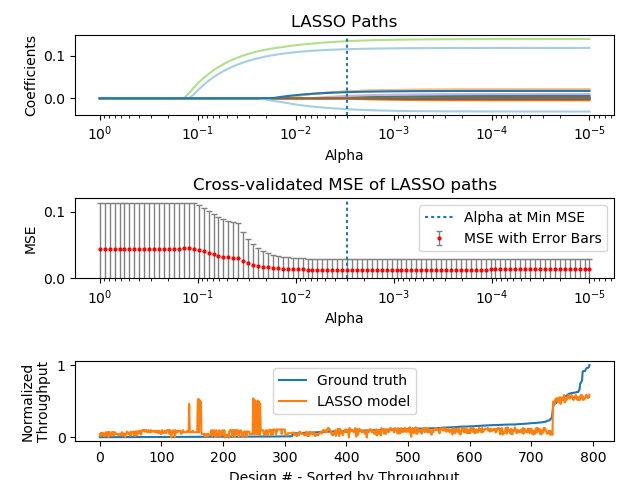

MSE 0.023619626641 std 0.0464242095904


<IPython.core.display.Javascript object>


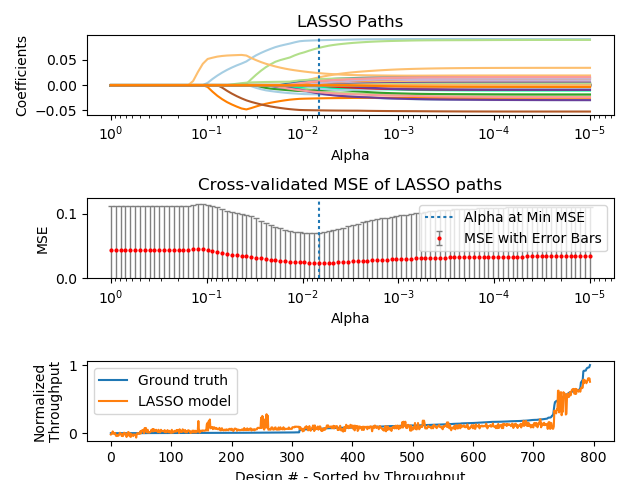

MSE 0.0108967498409 std 0.0148022318668


<IPython.core.display.Javascript object>


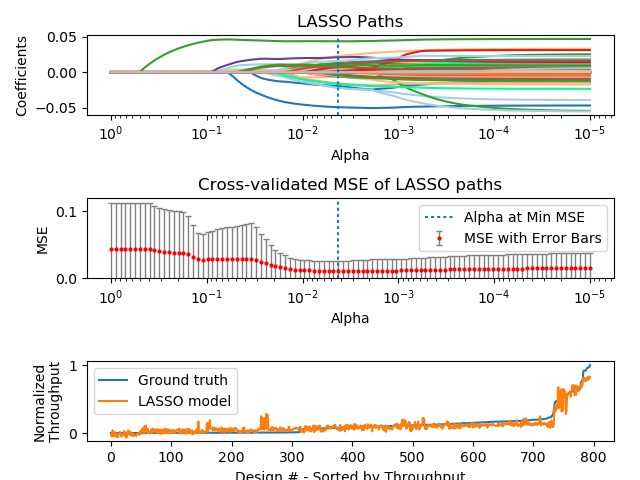

MSE 0.00942022587357 std 0.0175077544155


<IPython.core.display.Javascript object>


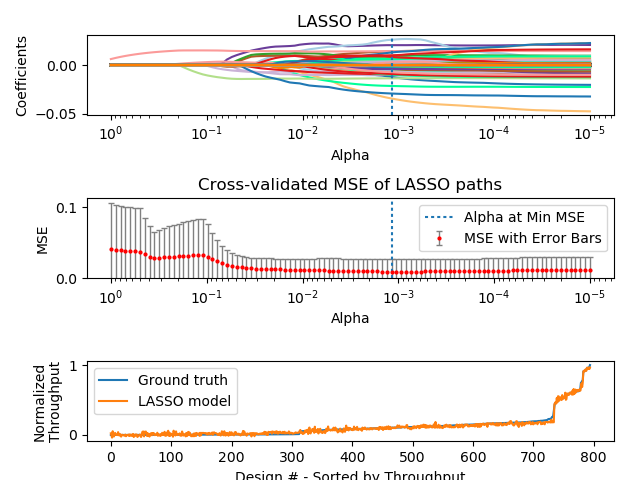

---------------- RAYCAST ----------------
MSE 0.010236781524 std 0.00252810567496


<IPython.core.display.Javascript object>


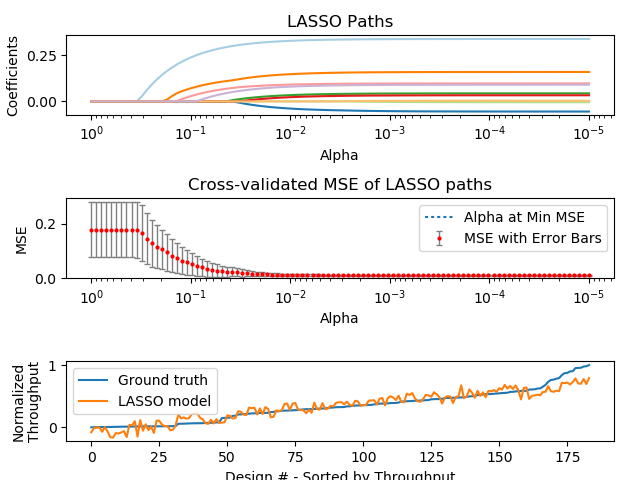

MSE 0.00470810148932 std 0.00226934332872


<IPython.core.display.Javascript object>


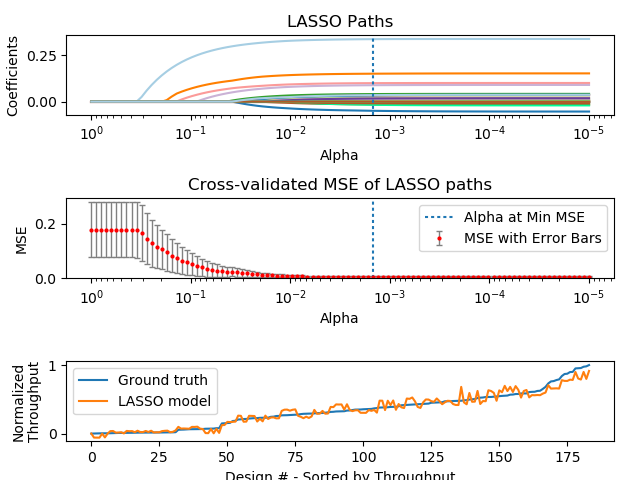

MSE 0.0028417045793 std 0.0011756641594


<IPython.core.display.Javascript object>


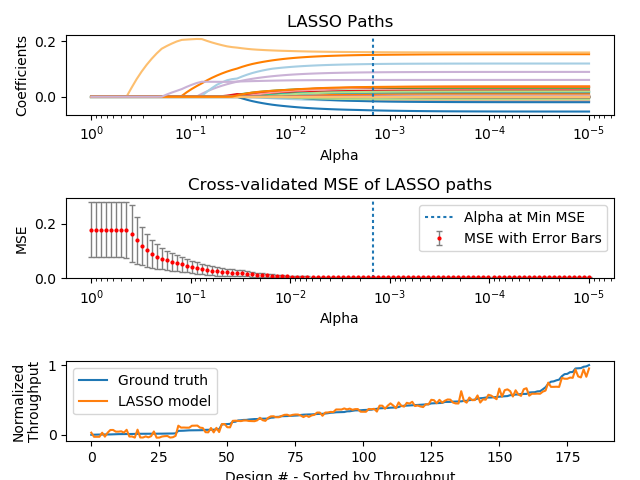

MSE 0.000871155891761 std 0.000501905314562


<IPython.core.display.Javascript object>


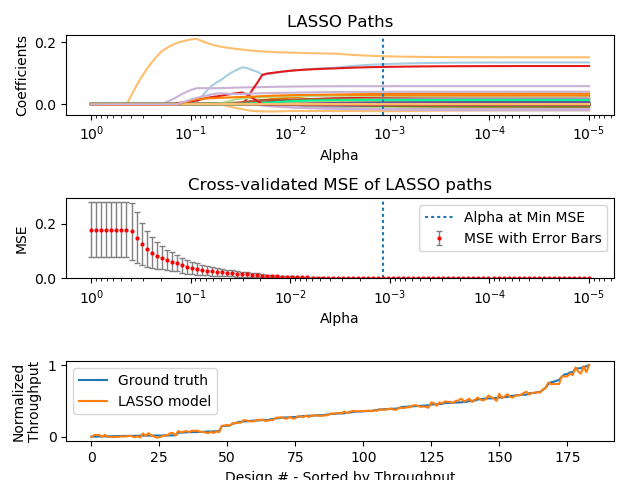

---------------- ICP ----------------
MSE 0.0121715828718 std 0.00549739196554


<IPython.core.display.Javascript object>


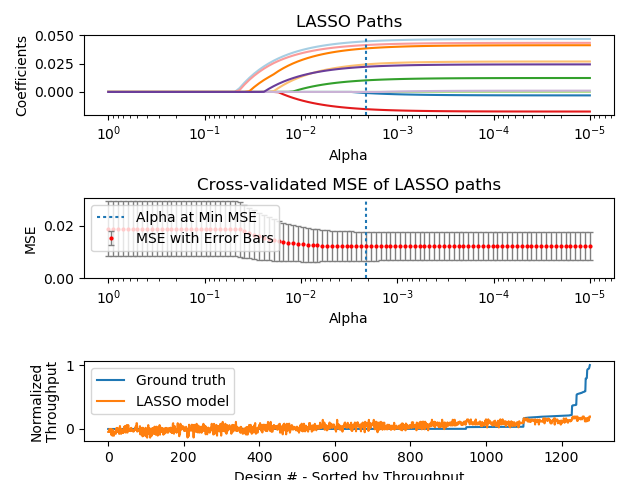

MSE 0.00777251564494 std 0.00341943962454


<IPython.core.display.Javascript object>


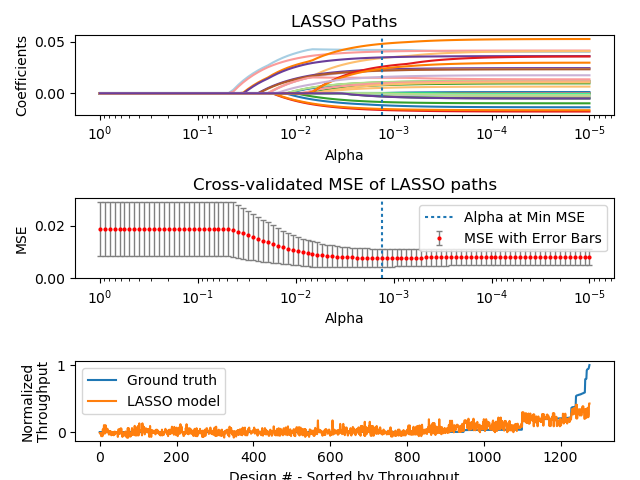

MSE 0.00725121367266 std 0.00293288974895


<IPython.core.display.Javascript object>


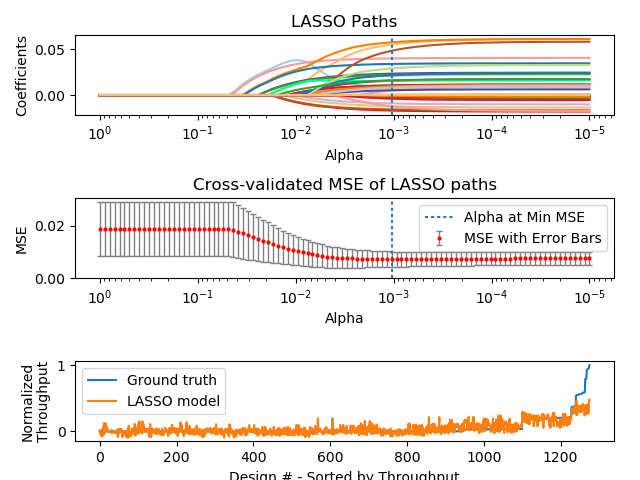

MSE 0.00235890674578 std 0.00061017903209


<IPython.core.display.Javascript object>


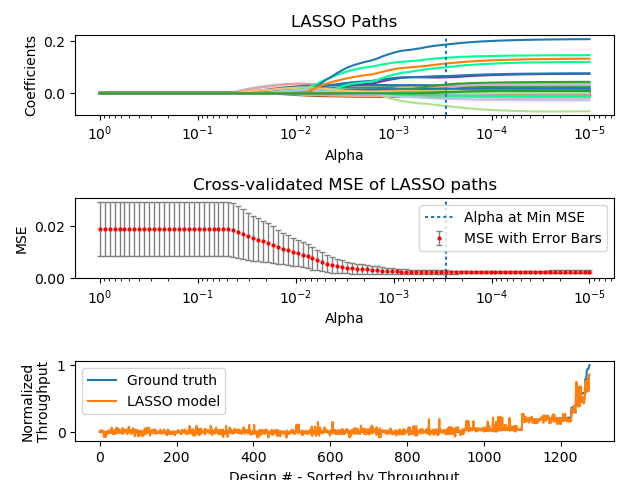

---------------- COMBINED ----------------
MSE 0.00331637105683 std 0.00271325106977


<IPython.core.display.Javascript object>


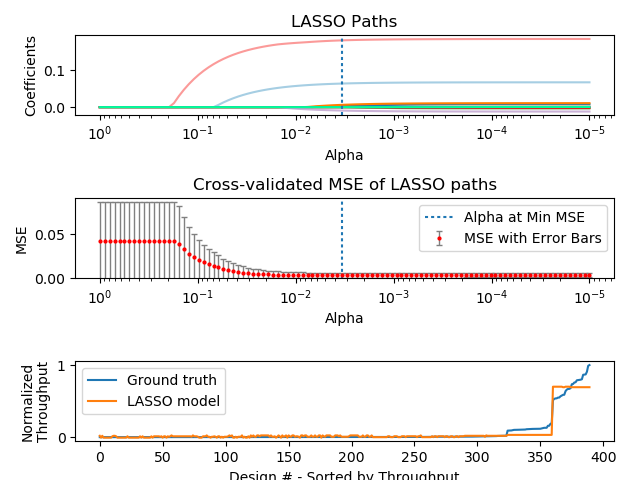

MSE 0.00204063063641 std 0.00195552320818


<IPython.core.display.Javascript object>


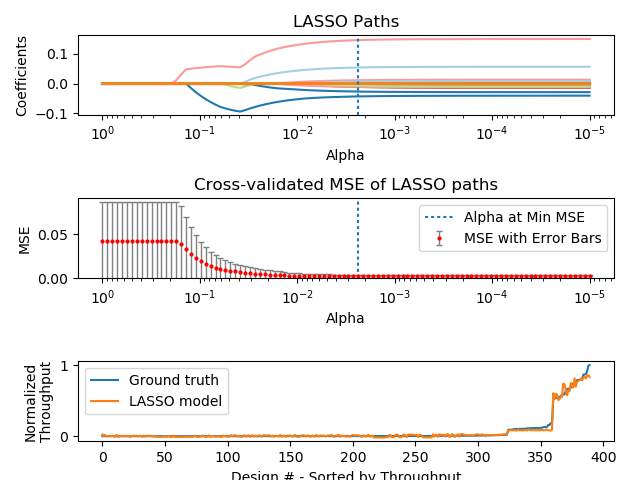

MSE 0.00202095894513 std 0.00197930318486


<IPython.core.display.Javascript object>


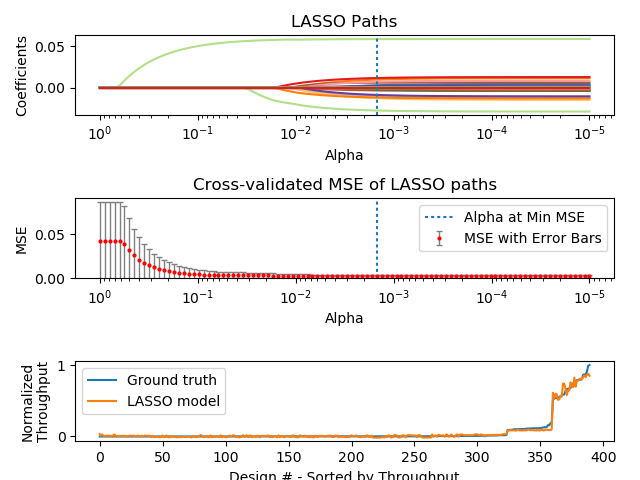

MSE 0.00187568595655 std 0.00209120434788


<IPython.core.display.Javascript object>


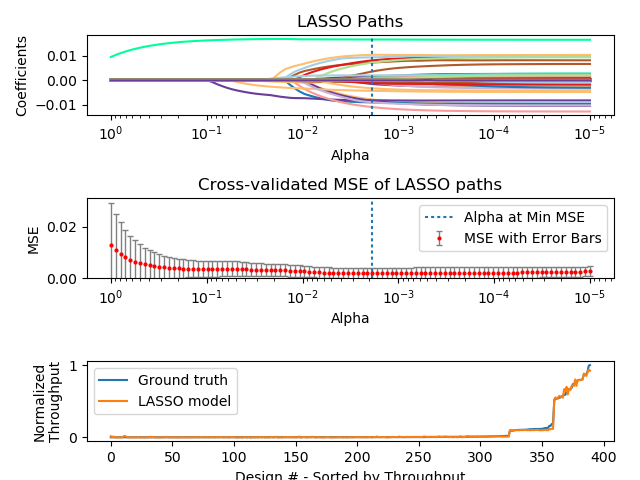

In [4]:

### DE5 PERFORMANCE
lasso = MyLasso(print_coefs=False,
                plot_data=True,
                n_jobs=4)

polynomials = [PolynomialFeatures(1), PolynomialFeatures(2, True), PolynomialFeatures(2), PolynomialFeatures(3)]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    print("---------------- DEPTH FUSION ----------------")
    for poly in polynomials:
        coefs = lasso.run_lasso(depth_data[0], performance, time_csv=depth_data[1], poly=poly)

    print("---------------- RAYCAST ----------------")
    for poly in polynomials:
        coefs = lasso.run_lasso(raycast_data[0], performance, time_csv=raycast_data[1], poly=poly)
    
    print("---------------- ICP ----------------")
    for poly in polynomials:
        coefs = lasso.run_lasso(icp_data[0], performance, time_csv=icp_data[1], poly=poly)
    
    print("---------------- COMBINED ----------------")
    for poly in polynomials:
        coefs = lasso.run_lasso(combined_data[0], performance, time_csv=combined_data[1], poly=poly)
    

---
# DE1 Performance

---------------- DEPTH FUSION ----------------
MSE 0.0193299341483 std 0.0114932400419


<IPython.core.display.Javascript object>


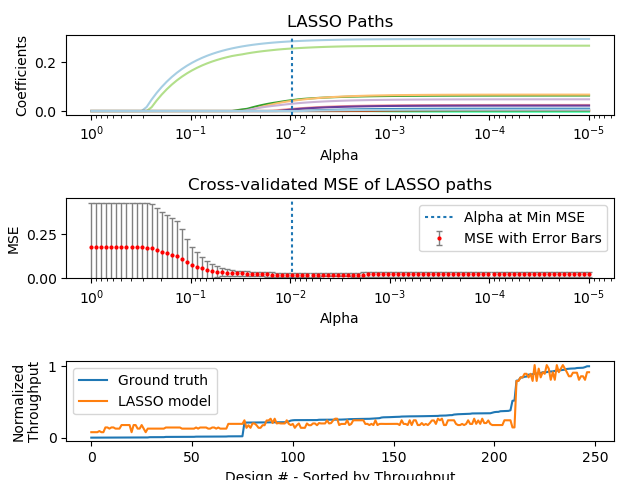

MSE 0.010506111631 std 0.0072214884856


<IPython.core.display.Javascript object>


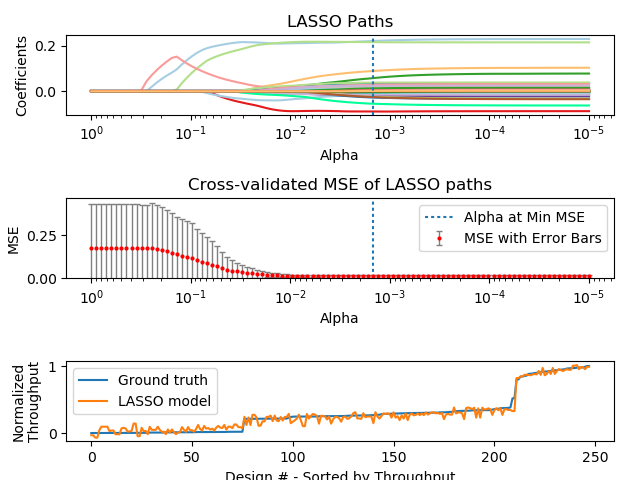

MSE 0.0080701085323 std 0.00389718572093


<IPython.core.display.Javascript object>


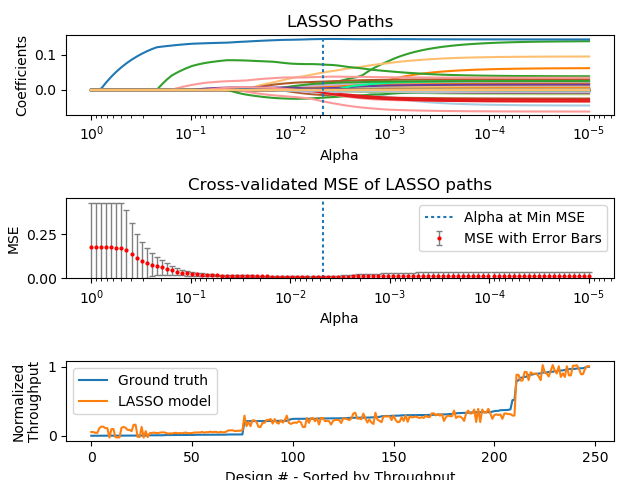

MSE 0.00593985797392 std 0.00318153946603


<IPython.core.display.Javascript object>


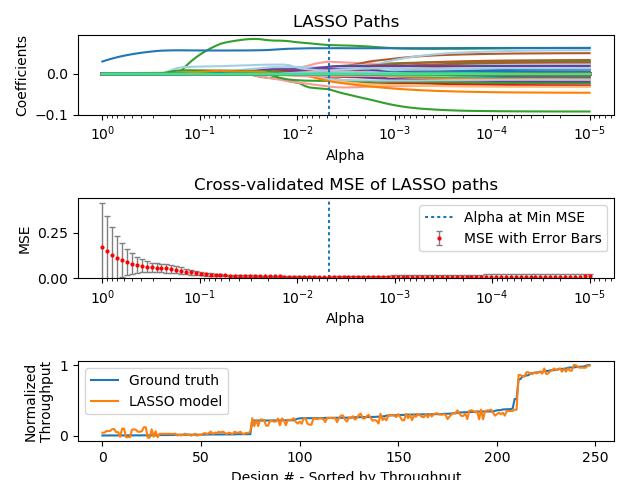

---------------- RAYCAST ----------------
MSE 0.015030269116 std 0.00733289876376


<IPython.core.display.Javascript object>


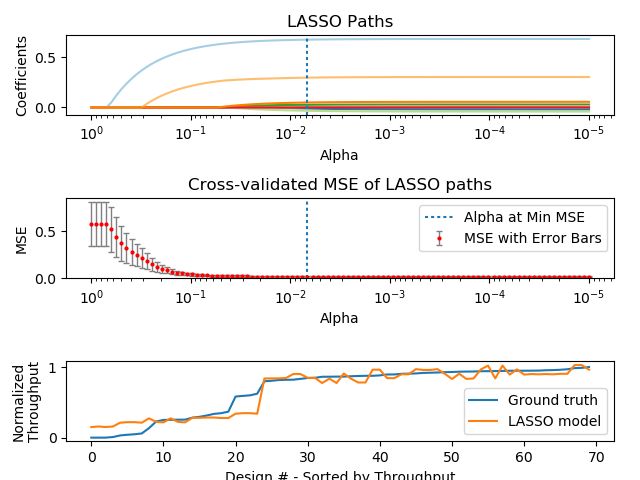

MSE 0.00184301452159 std 0.00113876390273


<IPython.core.display.Javascript object>


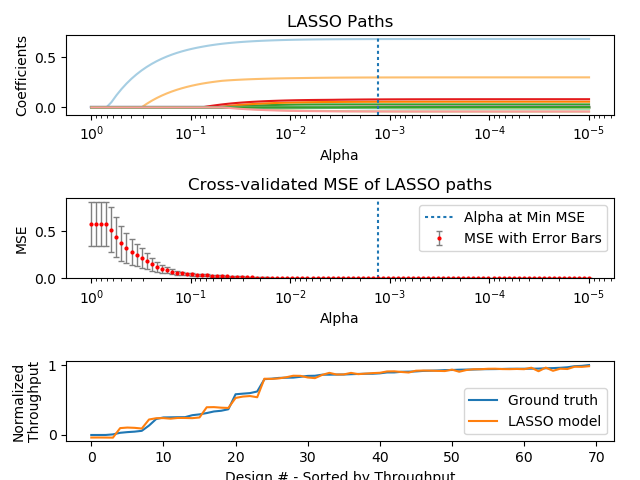

MSE 0.00139138612271 std 0.000929303120162


<IPython.core.display.Javascript object>


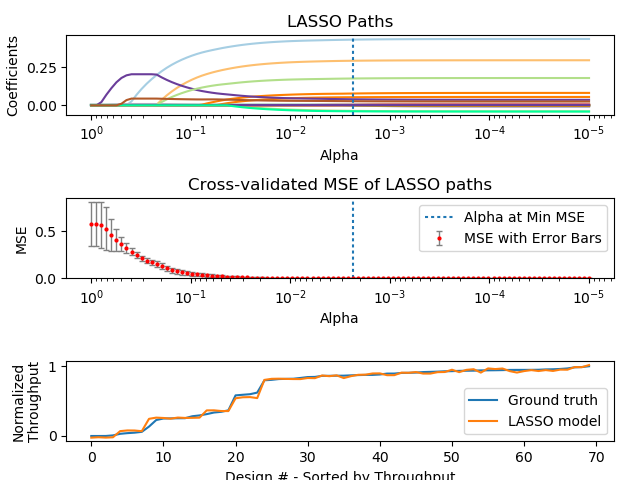

MSE 0.000715707910875 std 0.000634406344623


<IPython.core.display.Javascript object>


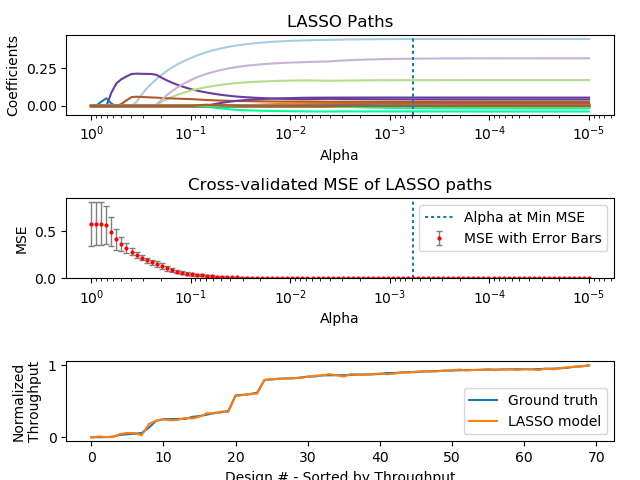

---------------- ICP ----------------
MSE 0.00481479604662 std 0.00345073418279


<IPython.core.display.Javascript object>


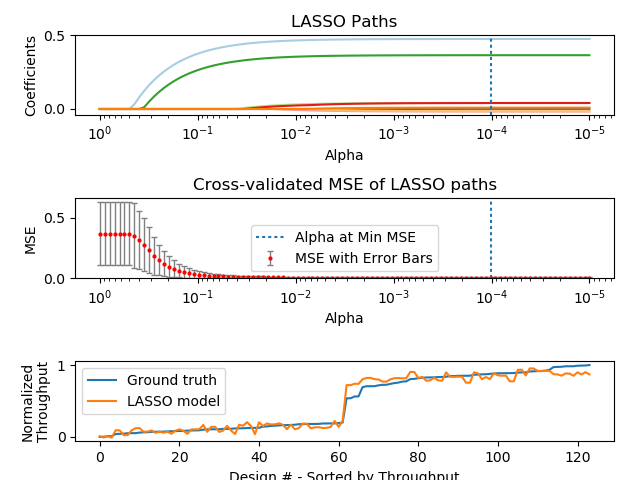

MSE 0.00398887514627 std 0.00206026359983


<IPython.core.display.Javascript object>


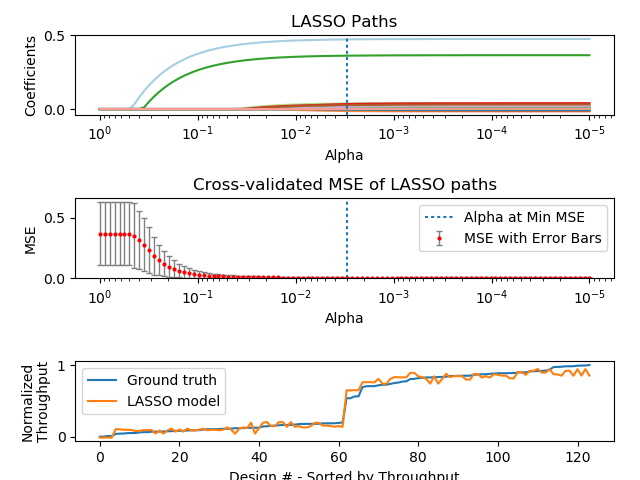

MSE 0.00391501621026 std 0.0019505858617


<IPython.core.display.Javascript object>


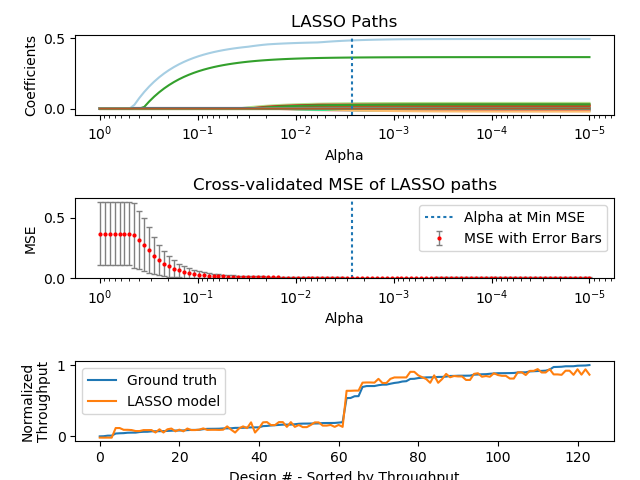

MSE 0.000751080658363 std 0.000276760866654


<IPython.core.display.Javascript object>


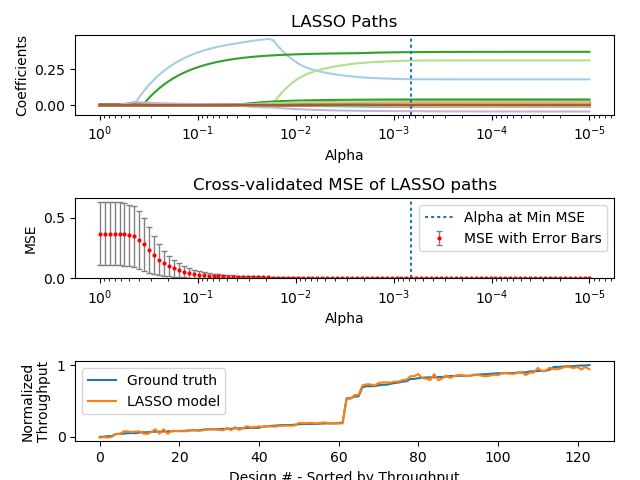

---------------- COMBINED ----------------
MSE 1.1817936954e-05 std 2.44889038262e-05


<IPython.core.display.Javascript object>


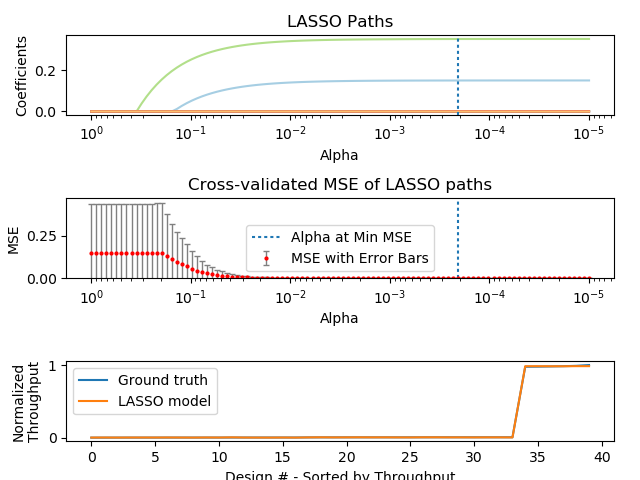

MSE 0.0655340299456 std 0.131062189705


<IPython.core.display.Javascript object>


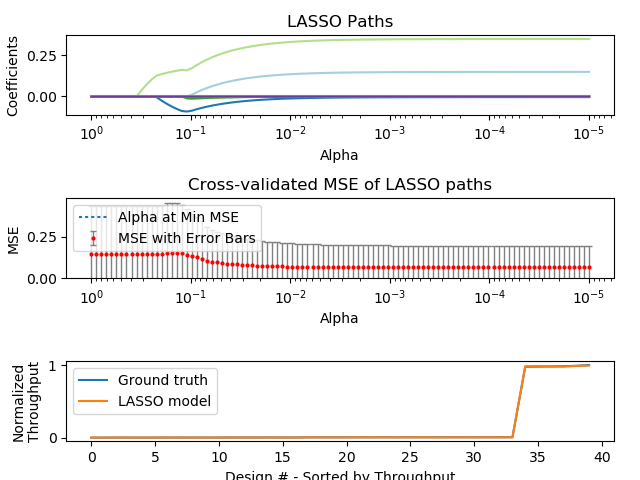

MSE 1.28966045263e-05 std 2.18817546837e-05


<IPython.core.display.Javascript object>


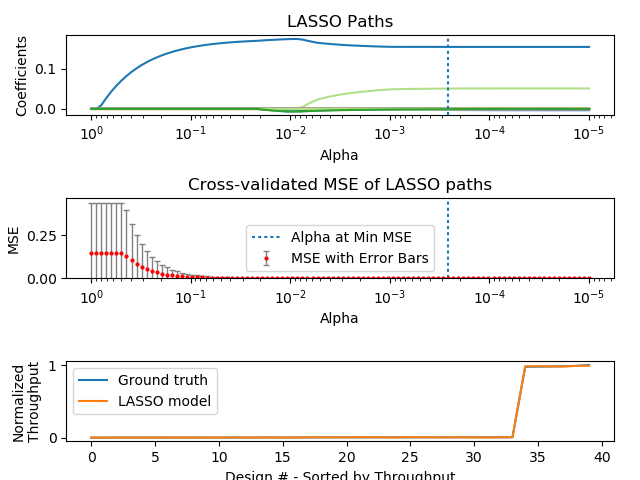

MSE 7.30592971739e-06 std 1.22343462146e-05


<IPython.core.display.Javascript object>


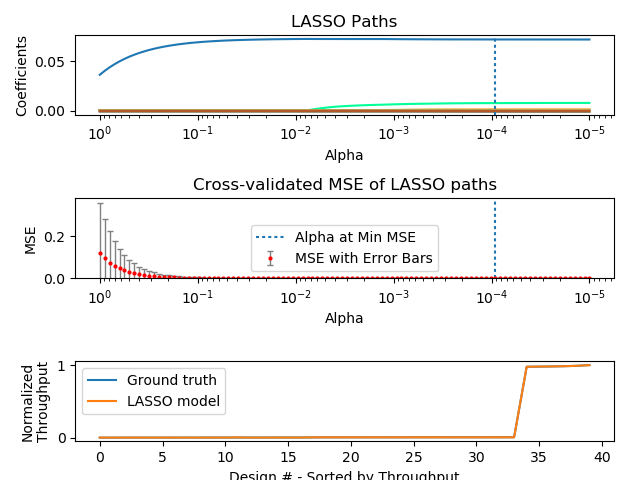

In [37]:

### DE1 PERFORMANCE
lasso = MyLasso(print_coefs=False,
                plot_data=True,
                n_jobs=4)

polynomials = [PolynomialFeatures(1), PolynomialFeatures(2, True), PolynomialFeatures(2), PolynomialFeatures(3)]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    print("---------------- DEPTH FUSION ----------------")
    for poly in polynomials:
        lasso.run_lasso(de1_depth_data[0], performance, time_csv=de1_depth_data[1], poly=poly)
    
    print("---------------- RAYCAST ----------------")
    for poly in polynomials:
        lasso.run_lasso(de1_raycast_data[0], performance, time_csv=de1_raycast_data[1], poly=poly)
    
    print("---------------- ICP ----------------")
    for poly in polynomials:
        lasso.run_lasso(de1_icp_data[0], performance, time_csv=de1_icp_data[1], poly=poly)
    
    print("---------------- COMBINED ----------------")
    for poly in polynomials:
        lasso.run_lasso(de1_combined_data[0], performance, time_csv=de1_combined_data[1], poly=poly)
    

---
# DE5 Logic Utilization

---------------- DEPTH FUSION ----------------
MSE 0.0214593382148 std 0.0208319771103


<IPython.core.display.Javascript object>


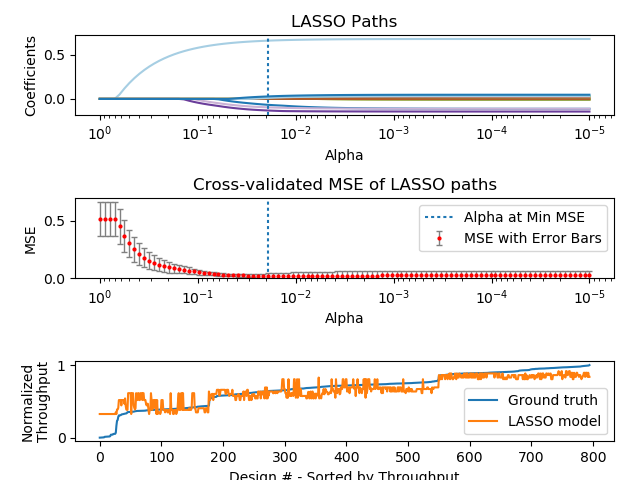

MSE 0.0167652296326 std 0.0262834634559


<IPython.core.display.Javascript object>


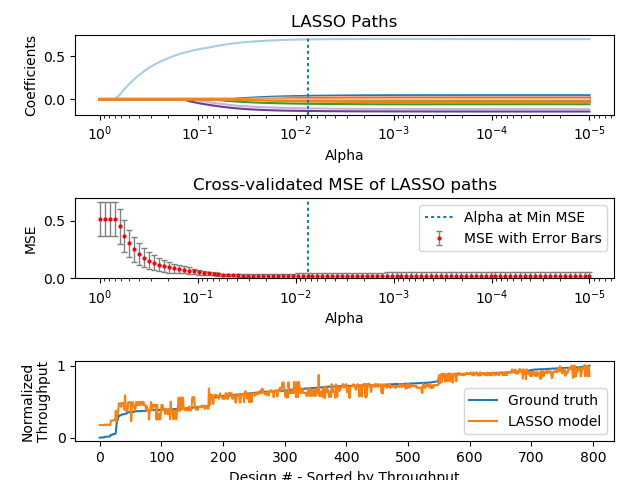

MSE 0.0171422347013 std 0.0327892547326


<IPython.core.display.Javascript object>


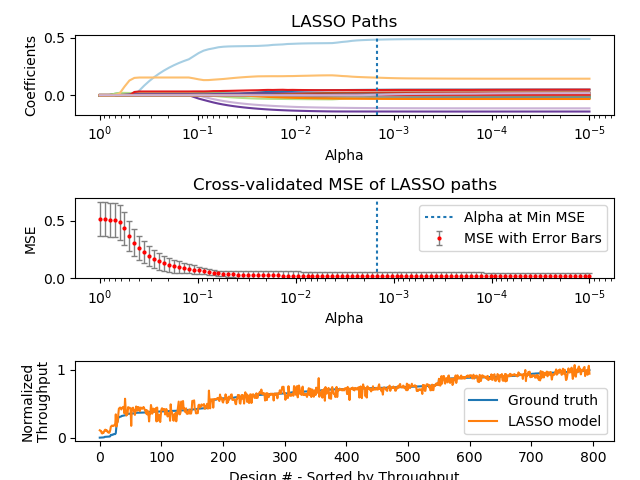

MSE 0.018374474933 std 0.0394430020033


<IPython.core.display.Javascript object>


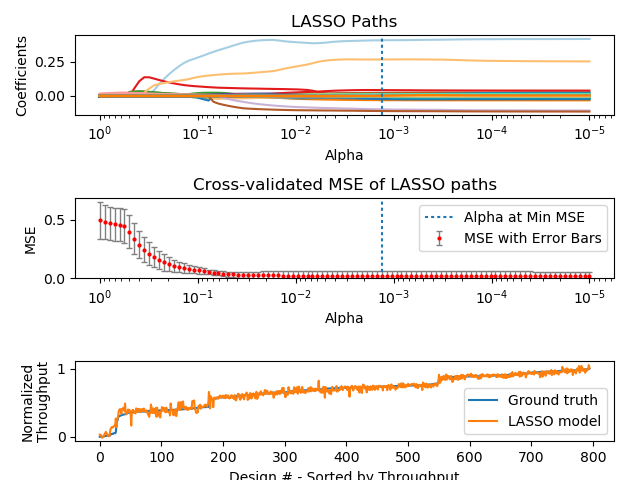

---------------- RAYCAST ----------------
MSE 0.00142339879555 std 0.000928306031723


<IPython.core.display.Javascript object>


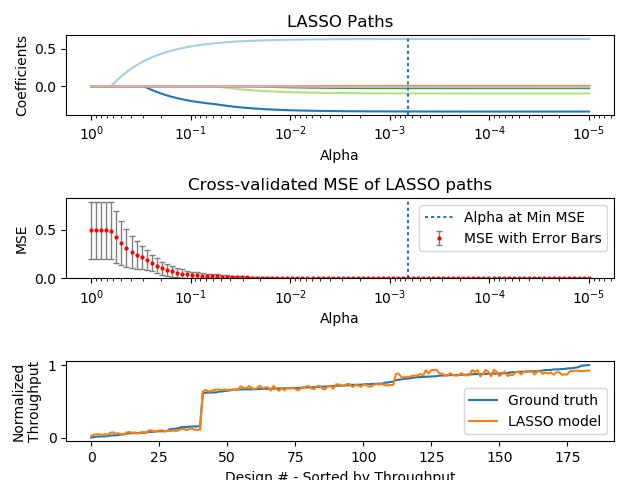

MSE 0.00143710797683 std 0.00107056492973


<IPython.core.display.Javascript object>


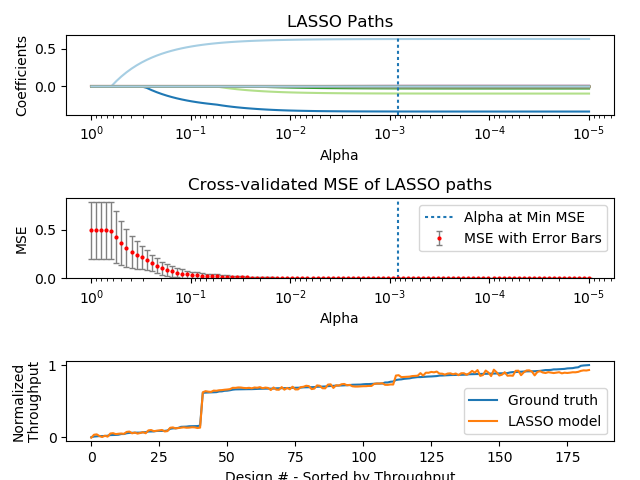

MSE 0.000962277404721 std 0.00091977579792


<IPython.core.display.Javascript object>


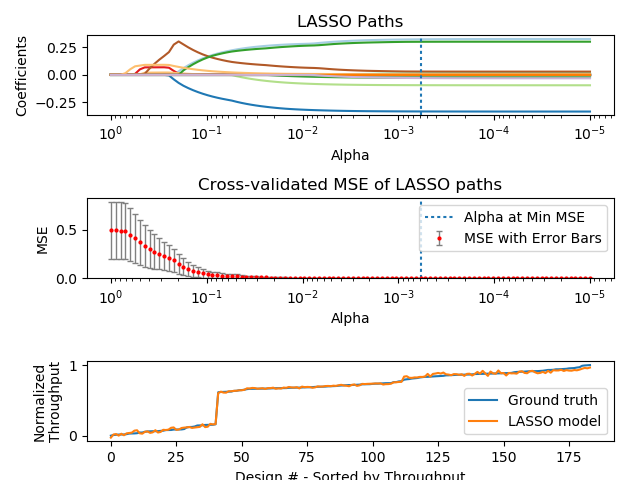

MSE 0.00110803937819 std 0.000957167497214


<IPython.core.display.Javascript object>


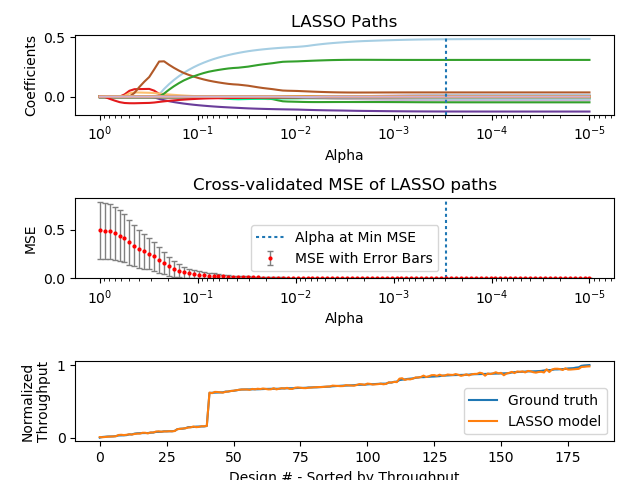

---------------- ICP ----------------
MSE 0.00620909693037 std 0.00154161718922


<IPython.core.display.Javascript object>


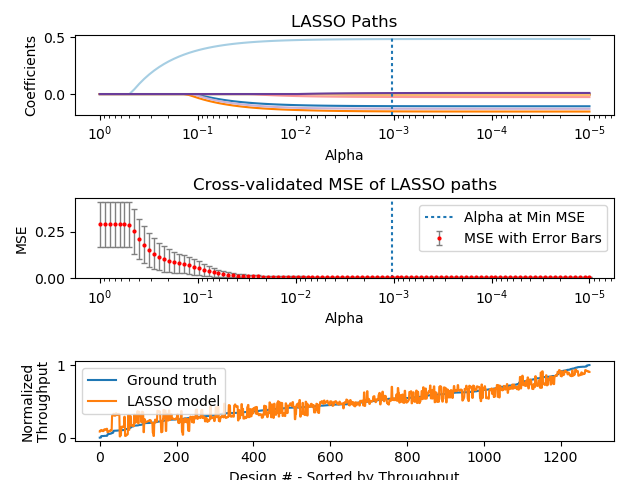

MSE 0.0019544684927 std 0.000695302869687


<IPython.core.display.Javascript object>


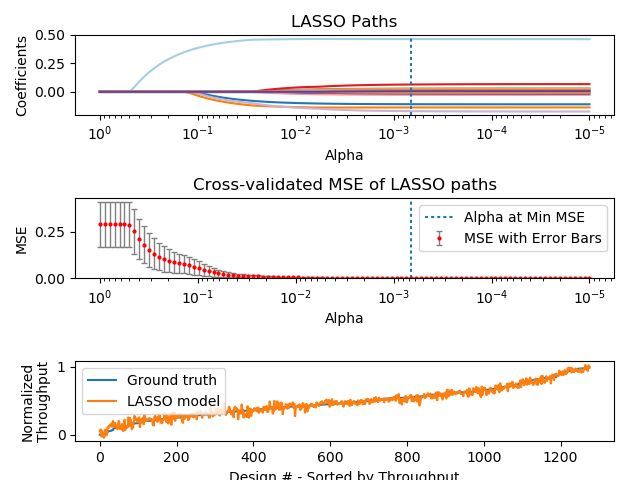

MSE 0.00144213312111 std 0.000476947317771


<IPython.core.display.Javascript object>


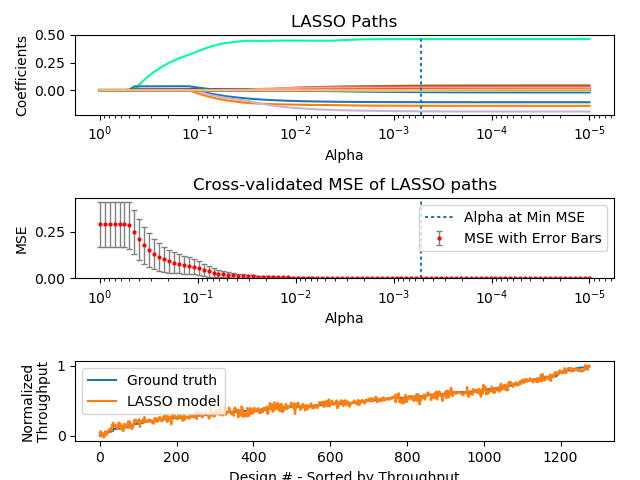

MSE 0.000396922987294 std 0.000152271042478


<IPython.core.display.Javascript object>


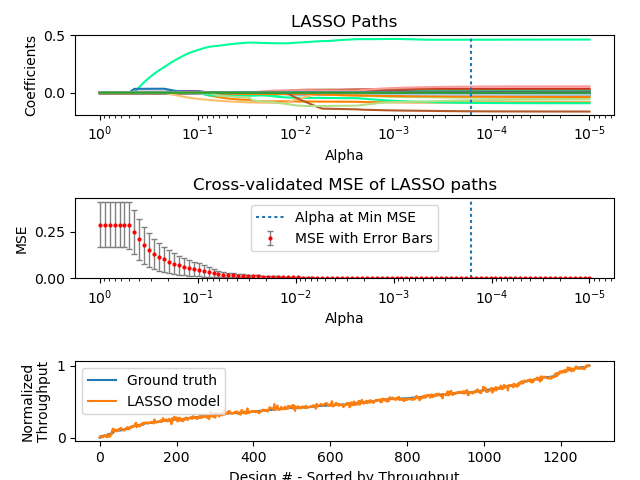

---------------- COMBINED ----------------
MSE 0.00161427009779 std 0.00127171123383


<IPython.core.display.Javascript object>


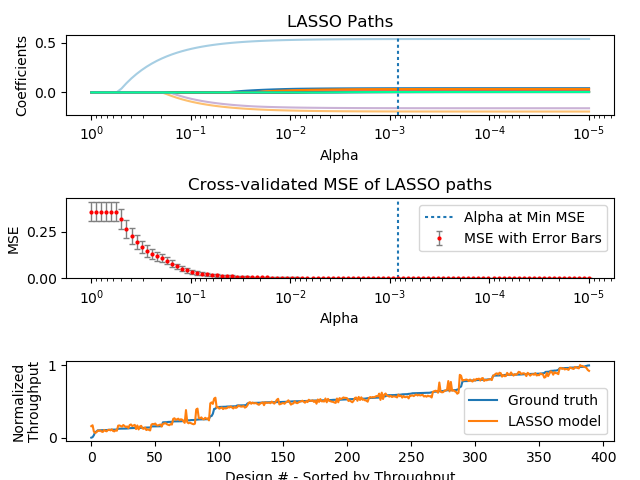

MSE 0.000923533657584 std 0.000664169523612


<IPython.core.display.Javascript object>


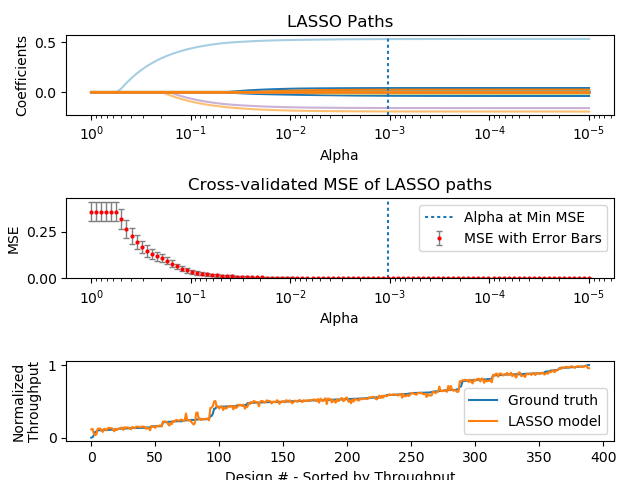

MSE 0.000804701209411 std 0.000520689302495


<IPython.core.display.Javascript object>


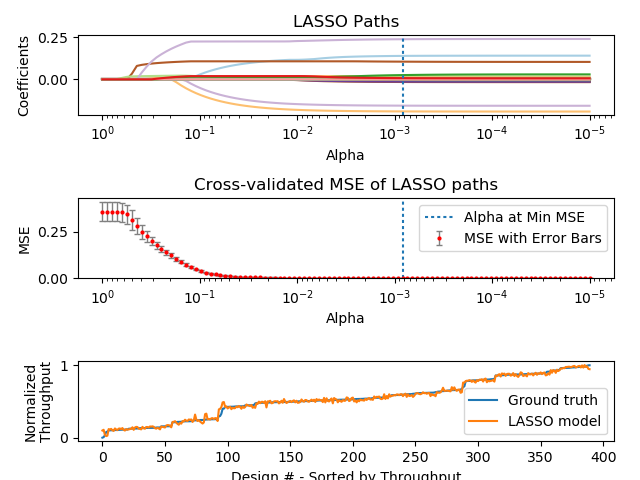

MSE 0.000417896912317 std 0.000236669392078


<IPython.core.display.Javascript object>


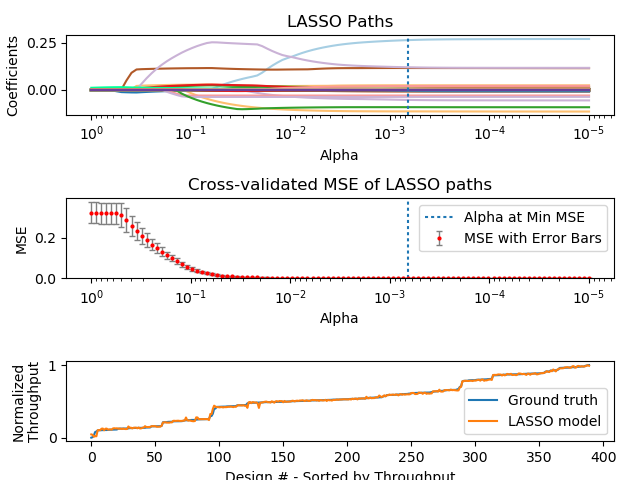

In [39]:

### LOGIC

lasso = MyLasso(print_coefs=False,
                plot_data=True,
                n_jobs=4)

polynomials = [PolynomialFeatures(1), PolynomialFeatures(2, True), PolynomialFeatures(2), PolynomialFeatures(3)]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    print("---------------- DEPTH FUSION ----------------")
    for poly in polynomials:
        lasso.run_lasso(depth_data[0], logic, time_csv=depth_data[1], poly=poly)
        
    print("---------------- RAYCAST ----------------")
    for poly in polynomials:
        lasso.run_lasso(raycast_data[0], logic, time_csv=raycast_data[1], poly=poly)
        
    print("---------------- ICP ----------------")
    for poly in polynomials:
        lasso.run_lasso(icp_data[0], logic, time_csv=icp_data[1], poly=poly)
    
    print("---------------- COMBINED ----------------")
    for poly in polynomials:
        lasso.run_lasso(combined_data[0], logic, time_csv=combined_data[1], poly=poly)

---
# DE5 ATE

---------------- DEPTH FUSION ----------------
MSE 0.0346219633173 std 0.00557632712207


<IPython.core.display.Javascript object>


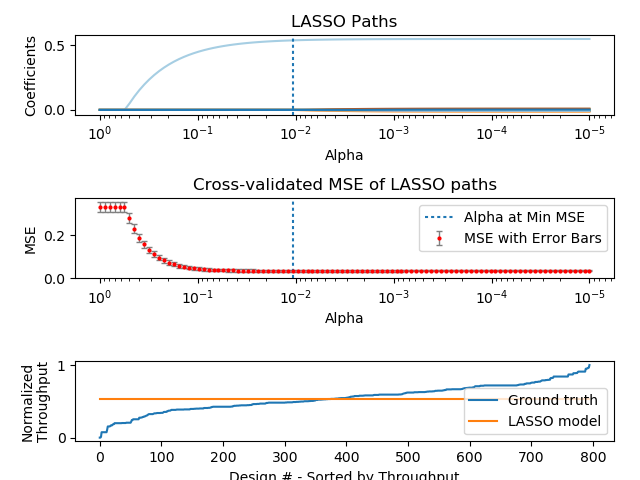

MSE 0.0345355227396 std 0.00554767226936


<IPython.core.display.Javascript object>


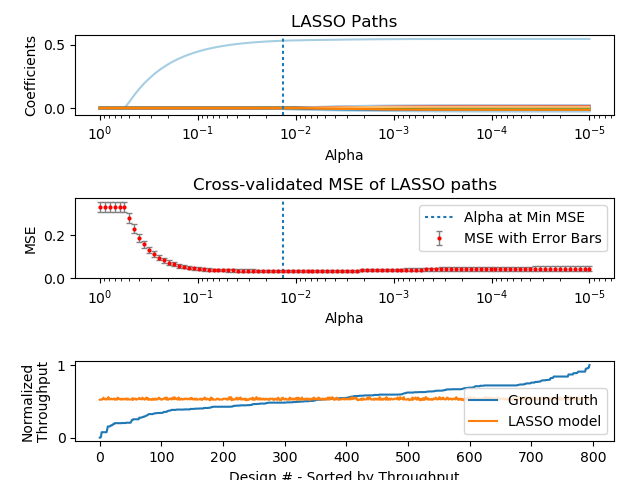

MSE 0.0350193873081 std 0.0050886806684


<IPython.core.display.Javascript object>


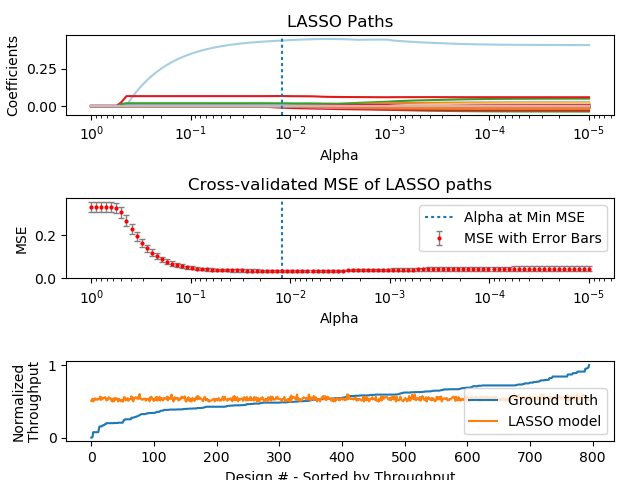

MSE 0.035553217872 std 0.00454533699692


<IPython.core.display.Javascript object>


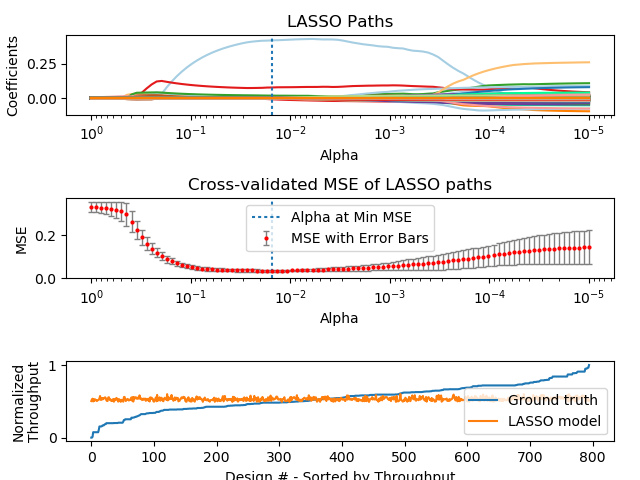

---------------- RAYCAST ----------------
MSE 0.00325762002596 std 0.00111022136467


<IPython.core.display.Javascript object>


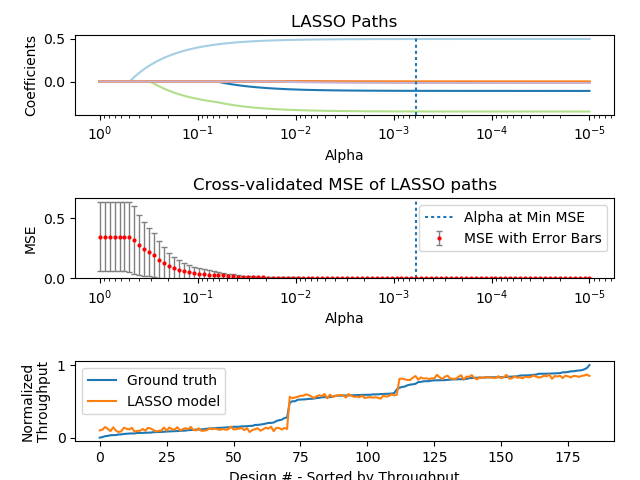

MSE 0.00371037269383 std 0.00113009623375


<IPython.core.display.Javascript object>


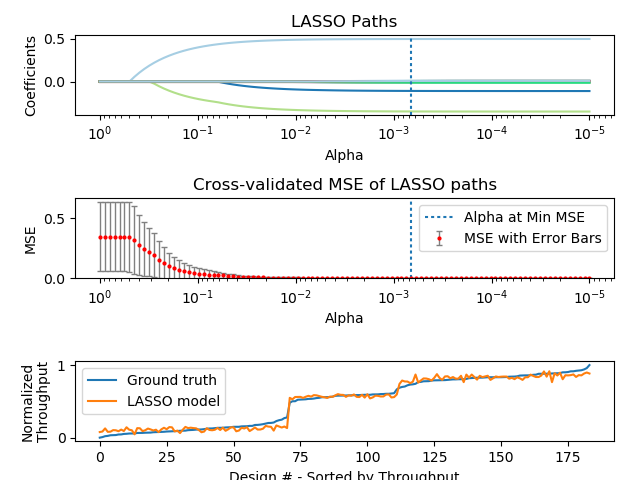

MSE 0.00364162475015 std 0.00140205242552


<IPython.core.display.Javascript object>


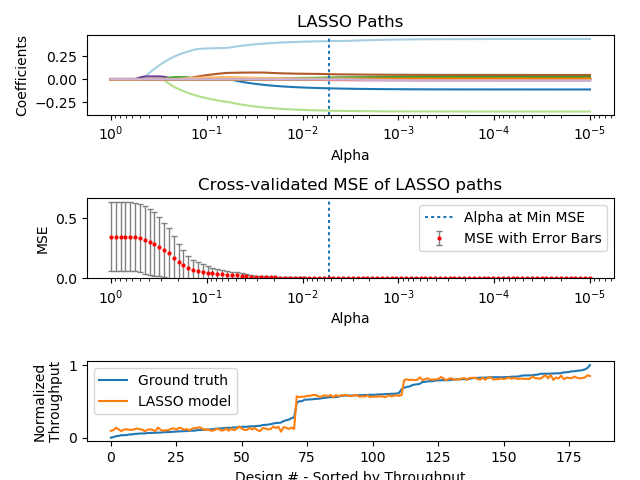

MSE 0.0037467293575 std 0.00127832225152


<IPython.core.display.Javascript object>


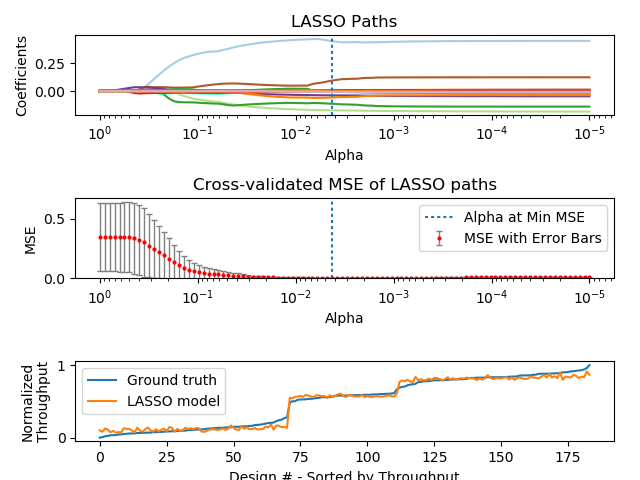

---------------- ICP ----------------
MSE 0.00547573206391 std 0.0026179912231


<IPython.core.display.Javascript object>


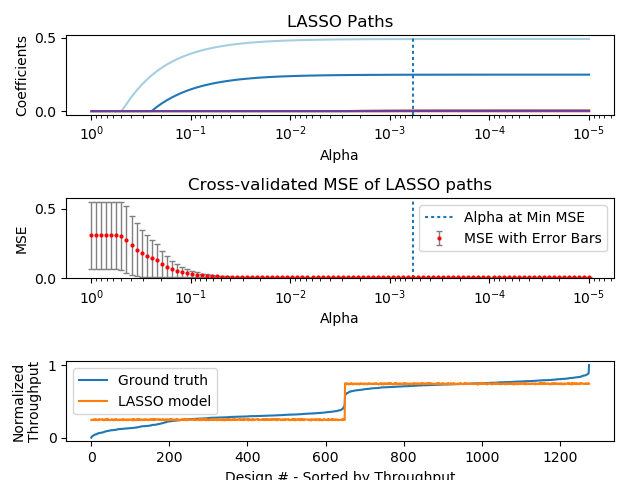

MSE 0.00550105419731 std 0.00256968801107


<IPython.core.display.Javascript object>


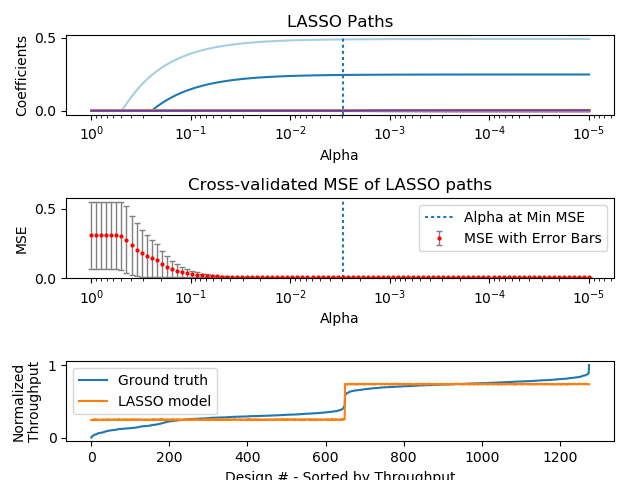

MSE 0.00550735969034 std 0.00256434862723


<IPython.core.display.Javascript object>


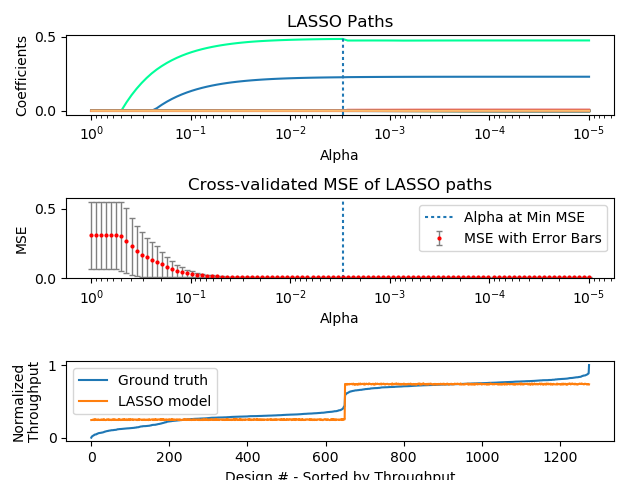

MSE 0.00544204438074 std 0.00249443611602


<IPython.core.display.Javascript object>


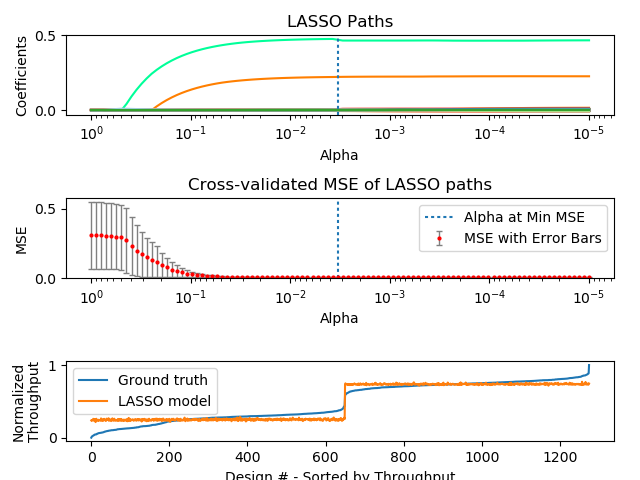

---------------- COMBINED ----------------
MSE 0.0157985357706 std 0.0162946442442


<IPython.core.display.Javascript object>


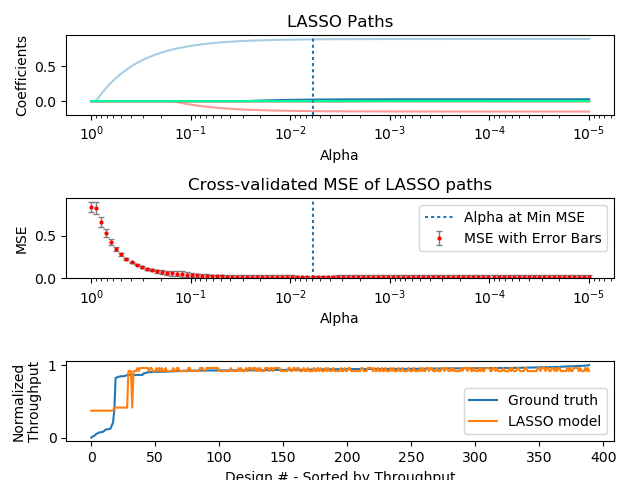

MSE 0.00148186009729 std 0.00152170616857


<IPython.core.display.Javascript object>


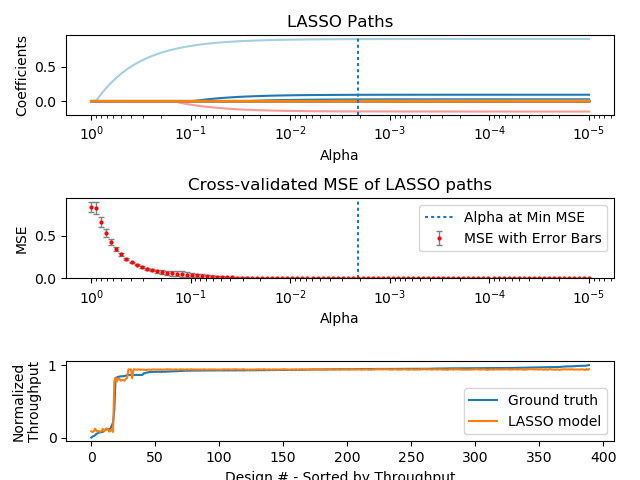

MSE 0.00143638472033 std 0.00156209785093


<IPython.core.display.Javascript object>


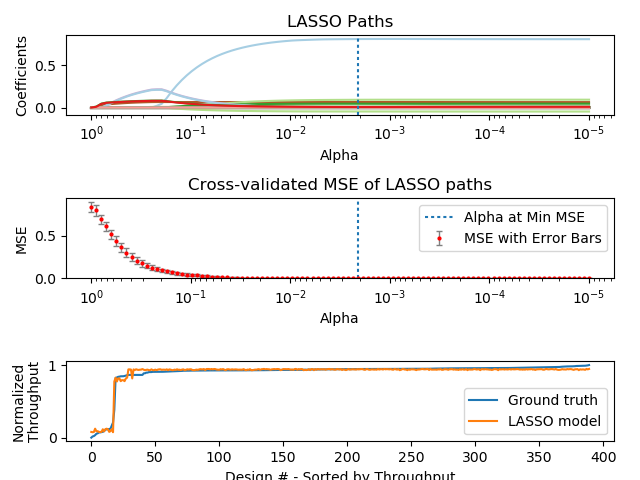

MSE 0.00151626310328 std 0.00156397006954


<IPython.core.display.Javascript object>


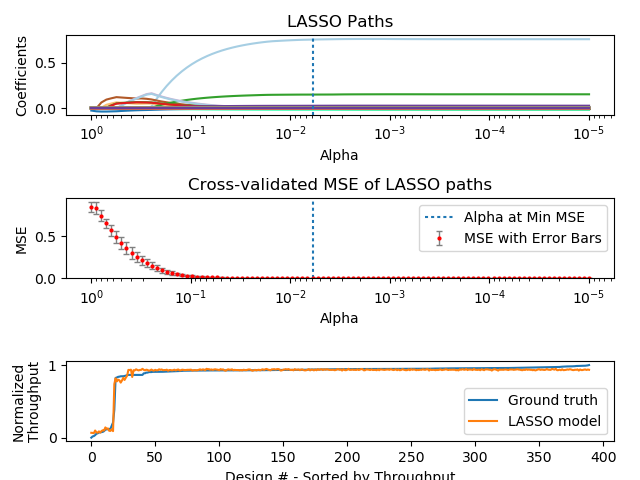

In [40]:

### ERROR

lasso = MyLasso(print_coefs=False,
                plot_data=True,
                n_jobs=4)

polynomials = [PolynomialFeatures(1), PolynomialFeatures(2, True), PolynomialFeatures(2), PolynomialFeatures(3)]


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    print("---------------- DEPTH FUSION ----------------")
    for poly in polynomials:
        lasso.run_lasso(depth_data[0], error, time_csv=depth_data[1], poly=poly)
        
    print("---------------- RAYCAST ----------------")
    for poly in polynomials:
        lasso.run_lasso(raycast_data[0], error, time_csv=raycast_data[1], poly=poly)
    
    print("---------------- ICP ----------------")
    for poly in polynomials:
        lasso.run_lasso(icp_data[0], error, time_csv=icp_data[1], poly=poly)
        
    print("---------------- COMBINED ----------------")
    for poly in polynomials:
        lasso.run_lasso(combined_data[0], error, time_csv=combined_data[1], poly=poly)